## Introduction

Welcome to the churn prediction and customer segmentation notebook ! In today's competitive market, understanding customer behavior and predicting churn are essential for businesses to retain their customers and ensure long-term success. This notebook presents a comprehensive analysis of churn prediction using the Telco dataset https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

Following the CRISP-DM (Cross-Industry Standard Process for Data Mining) methodology, I built a model for churn prediction. Then I tried to segment customers based on their historical data. And to finish it all, I added a small section to explain predictions using Shapley Values !

**Note** : If you want to run this notebook, please consider running "pip install -r requirements" before. The shap library version should be the same as mine to work.

## Environment preparation

This step consists of importing the most important modules and defining the most important variables for the notebook.

In [46]:
#!pip install -r telco-streamlit/requirements.txt

In [2]:
# modules import
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.cluster import KMeans
import shap
import pickle

# variables definition
random_seed = 42
test_size = 0.2

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Data Collection

The data collection consists of importing all datasets needed for the project.

In [3]:
df = pd.read_csv("input/WA_Fn-UseC_-Telco-Customer-Churn.csv")

## Data Understanding

Exploring the data by displaying the different values, their distributions and how they correlate with our target feature can help optimizing the results and better understand our machine learning model outputs.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Our dataset doesn't have any null value. But there are some data modifications that we need to perform before we start exploring the dataset. First, we need to convert TotalCharges to float. Then, we need to convert the Churn variable to a binary value (0 or 1).

In [5]:
df["Churn"] = df["Churn"].replace({"Yes" : True, "No" : False})
df['TotalCharges'] = df['TotalCharges'].replace({' ': 0}).astype(float)

### Exploring the target variable : Churn

<Axes: title={'center': 'Churn distribution'}, xlabel='Churn'>

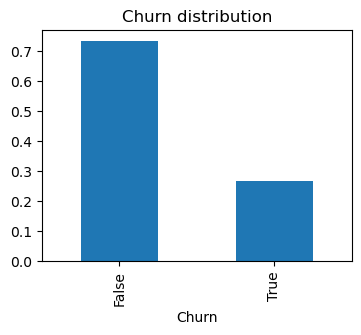

In [6]:
plt.figure(figsize=(4, 3))
df['Churn'].value_counts(normalize=True).plot(kind = 'bar', title = 'Churn distribution')

The churn variable is not balanced in our dataset. Therefore, we need to choose an appropriate metric for our prediction task. The 'ROC AUC Score' can be useful in this case.

### Exploring Categorical Variables

In [7]:
# This function plots in the same figure : the proportion of a categorical variable in the dataset, alongside the proportion of churn inside each category
def plot_cat_with_churn(df, var):
    counts = df.groupby(var, as_index = False).aggregate({"Churn" : ["sum", "count"]})
    counts.columns = [var, "number_of_churns", "category_count"]
    perc_churn = "percentage_churn_by_{}".format(var)
    perc_var = "percentage_{}_in_dataset".format(var)
    counts[perc_churn] = counts["number_of_churns"]/counts["category_count"]
    counts[perc_var] = counts["category_count"]/df.shape[0]
    counts = counts[[var, perc_churn, perc_var]]
    counts = pd.melt(counts, id_vars = [var], var_name='ratio', value_name='value')
    plt.figure(figsize=(5, 2))
    plt.xticks(rotation=5)
    sns.barplot(x='ratio', y='value', hue=var, data=counts, width=0.4)

#### Gender

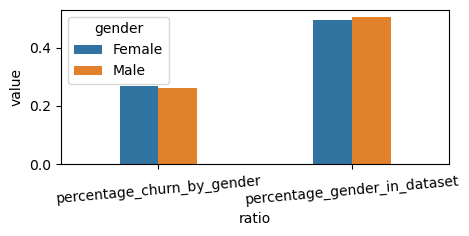

In [8]:
plot_cat_with_churn(df, "gender")

The gender is equally distributed in our dataset. Moreover, it's not correlated with our churn variable, because in each gender category we have the same churn proportions (~26%)

#### SeniorCitizen

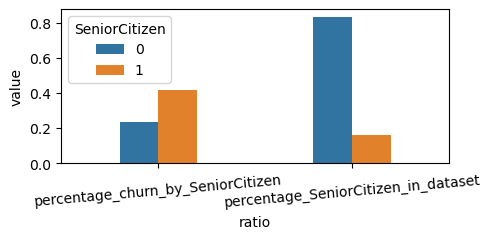

In [9]:
plot_cat_with_churn(df, "SeniorCitizen")

SeniorCitizen is not equally distributed in our dataset (\~20% are seniors). Moreover, seniors are more likely to churn (\~41%) compared to younger categories (\~20%). Therefore, SeniorCitizen might be an important feature in our prediction.

Remark : The variable age would have been more useful to get insights from more age categories. But this feature is not available in our dataset.

#### Partner

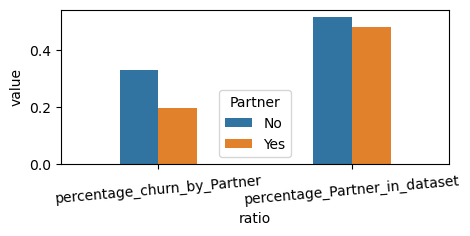

In [10]:
plot_cat_with_churn(df, "Partner")

Partner is equally distributed in our dataset. Moreover, customers with no partners are more likely to churn (\~32%) compared to those with a partner (\~20%). Therefore, Partner might be an important feature in our prediction.

#### Dependents

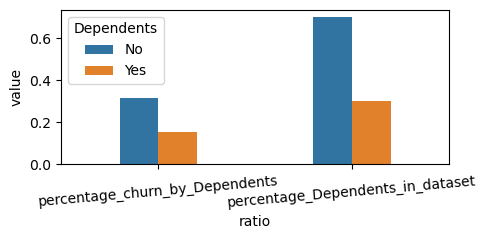

In [11]:
plot_cat_with_churn(df, "Dependents")

Dependents is not equally distributed in our dataset. Moreover, customers with no Dependents are more likely to churn (\~32%) compared to those with a partner (\~16%). Therefore, Dependents might be an important feature in our prediction.

#### PhoneService

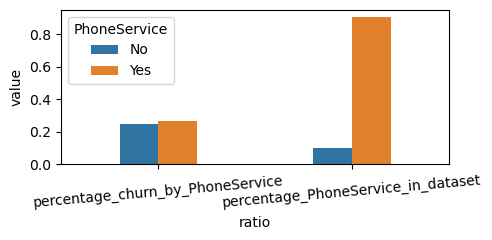

In [12]:
plot_cat_with_churn(df, "PhoneService")

This variable is not equally distributed, and churn proportions for each value is the same. Which makes it a less relevant feature for our prediction.

#### MultipleLines

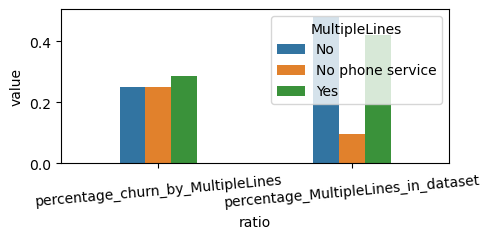

In [13]:
plot_cat_with_churn(df, "MultipleLines")

The churn proportions for each value of MultipleLines is the same. Which makes it a less relevant feature for our prediction.

#### InternetService

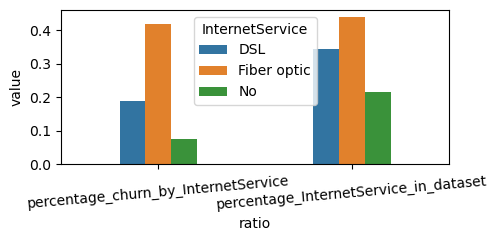

In [14]:
plot_cat_with_churn(df, "InternetService")

Customers with a fiber service are more likely to churn. This feature could be useful to our modelisation process.

#### OnlineSecurity

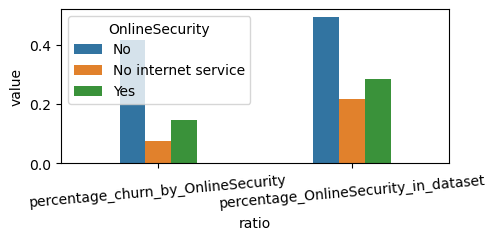

In [15]:
plot_cat_with_churn(df, "OnlineSecurity")

Customers without OnlineSecurity are more likely to churn.

#### OnlineBackup

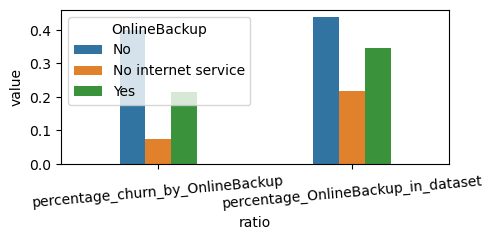

In [16]:
plot_cat_with_churn(df, "OnlineBackup")

Clients without any OnlineBackup are more likely to churn.

#### DeviceProtection

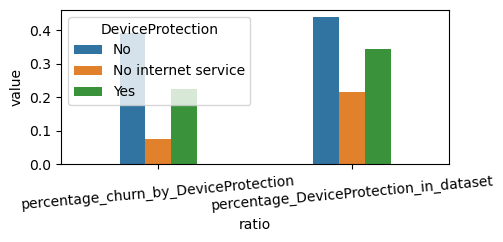

In [17]:
plot_cat_with_churn(df, "DeviceProtection")

Customers without DeviceProtection are more likely to churn.

#### TechSupport

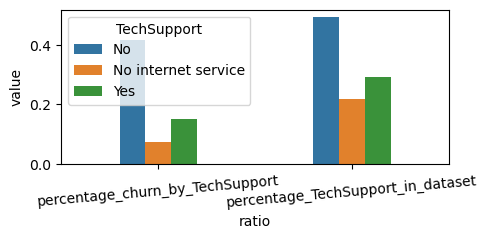

In [18]:
plot_cat_with_churn(df, "TechSupport")

Customers without TechSupport are more likely to churn.

#### StreamingTV

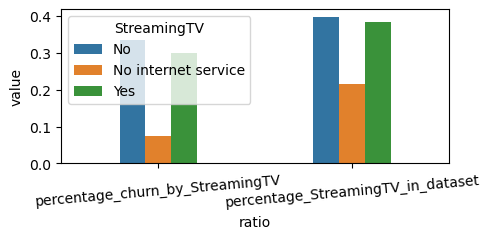

In [19]:
plot_cat_with_churn(df, "StreamingTV")

The proportion of Churn is equal between customers who have streamingTV service and customers who don't have it. This feature is not relevant for our prediction.

#### StreamingMovies

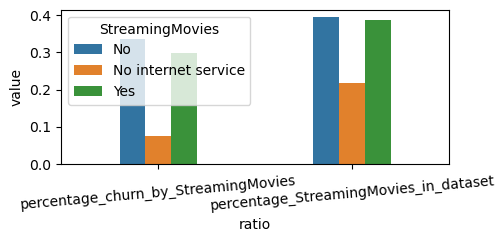

In [20]:
plot_cat_with_churn(df, "StreamingMovies")

The proportion of Churn is equal between customers who have streamingMovies service and customers who don't have it. This feature is not relevant for our prediction.

#### Contract

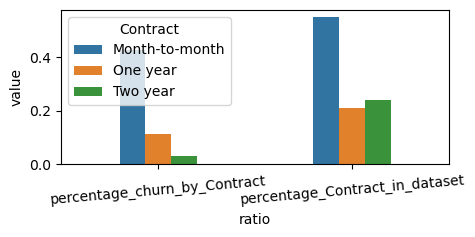

In [21]:
plot_cat_with_churn(df, "Contract")

Month to Month contracts are more likely to churn compared to one year and two years contracts.

#### PaperlessBilling

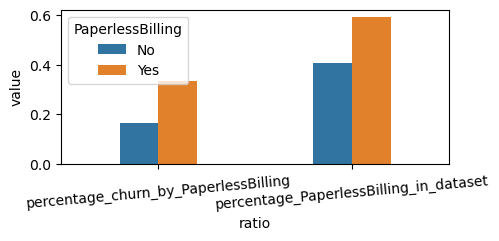

In [22]:
plot_cat_with_churn(df, "PaperlessBilling")

Customers with PaperlessBilling are more likely to churn by (\~16% more).

#### PaymentMethod

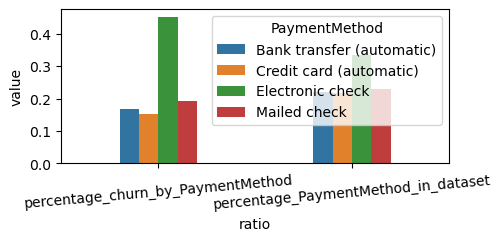

In [23]:
plot_cat_with_churn(df, "PaymentMethod")

Customers with Electronic check payment method are more likely to churn compared to other customers

#### Conclusion

For our churn prediction task, we will remove the following features :
* StreamingMovies
* StreamingTV
* MultipleLines
* PhoneService
* Gender

Those variables are not correlated with the churn variables.

### Exploring Numerical Variables

In order to analyze numerical variables and how it correlates with our target feature, the boxplots are a good choice. If boxplots distribution looks the same, the it means that the churn variable is not correlated with our target feature.

In [24]:
# Display boxplots for each churn value (0 or 1)
def churn_boxplots(df, var):
    plt.figure(figsize=(5, 3))
    plt.title('{} and Churn correlations'.format(var))
    plt.ylabel('Churn')
    plt.xlabel(var)
    sns.boxplot(x=df[var], y=df['Churn'].astype(str))

#### TotalCharges

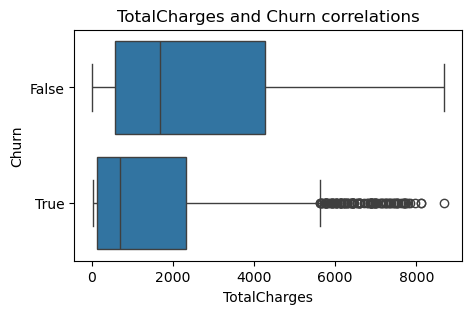

In [25]:
churn_boxplots(df, 'TotalCharges')

Customers with more important TotalCharges are less likely to churn.

#### MonthlyCharges

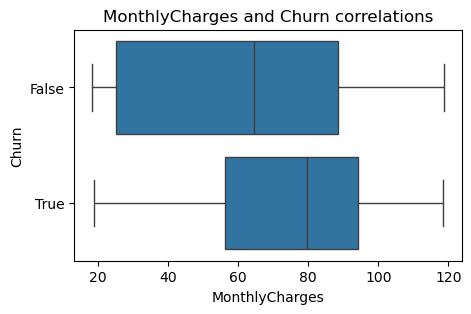

In [26]:
churn_boxplots(df, 'MonthlyCharges')

Customers with more important MonthlyCharges are more likely to churn.

#### tenure

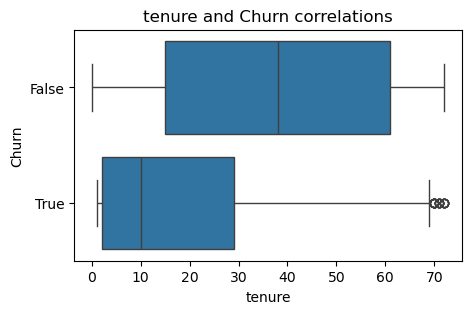

In [27]:
churn_boxplots(df, 'tenure')

More recent customers are more likely to churn.

#### Conclusion

All numerical variables seem to be correlated with our churn target value.

## Data Preparation

### Feature Engineering

For our feature engineering process, there are some new features that we thought of :
* Combining tenure with Contract : from tenure value, we can know if each customer is still bound to the contract or not (Example : A one year contract with a tenure of only 2 months mean that the customer didn't finish his engagement)
* We can compare TotalCharges with tenure\*MonthlyCharges. if TotalCharges < tenure\*MonthlyCharges, it means that his MonthlyCharges increased during his contract. if TotalCharges > tenure\*MonthlyCharges, it means that MonthlyCharges decreased compared to before, although there might be some cases where customers asked for some special services which costed them some money before. For this feature, we will just calculate TotalCharges - tenure\*MonthlyCharges and see if it correlates somehow with churn variable.

In [28]:
df["ongoingCommitment"] = np.where(((df['Contract'] == 'One year') & (df['tenure'] < 12)) 
                                   | ((df['Contract'] == 'Two year') & (df['tenure'] < 24))
                                   , 1
                                   , 0)

df["MonthlyChargesIncrease"] = df["TotalCharges"] - df["tenure"]*df["MonthlyCharges"]

#### ongoingCommitment

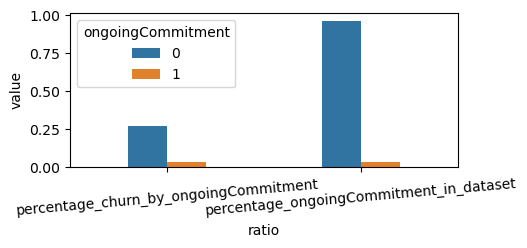

In [29]:
plot_cat_with_churn(df, "ongoingCommitment")

the churn proportion of customers under an ongoing commitment is really low ~3%. Which could make it a good candidate for our prediction. But unfortunately, customers under an ongoing commitment represents only ~3% of the whole dataset, which makes it a useless feature for our prediction.

#### MonthlyChargesIncrease

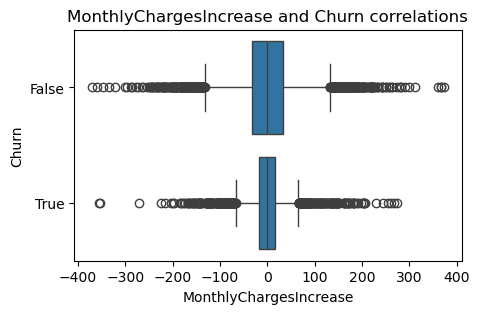

In [30]:
churn_boxplots(df, 'MonthlyChargesIncrease')

MonthlyChargesIncrease doesn't seem to be correlated with the churn variable. The distribution is almost the same in both boxplots.

#### Conclusion

The feature engineering didn't conclude to good new features for our predictions.

### Data Cleaning

Data seems to be in good quality and don't require further cleaning. We will remove features mentioned above and ID column and perform one-hot encoding on categories :

In [31]:
drop_features = ["customerID", "StreamingMovies", "StreamingTV", 
                 "MultipleLines", "PhoneService", "gender", "ongoingCommitment",
                "MonthlyChargesIncrease"]
df = df.drop(drop_features, axis=1)

# One-hot encoding categorical variables
df = pd.get_dummies(df, drop_first=True)

## Modelisation

For our modelisation steps, we will test 2 machine learning models (Random Forest & lightgbm) :

#### LightGBM

In [32]:
# Splitting the data into features and target variable
X = df.drop('Churn', axis=1)
y = df['Churn']

# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

# Convert the dataset into LightGBM format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Set parameters for LightGBM
params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 16,  # Adjust as per your requirements
    'learning_rate': 0.05,  # Adjust as per your requirements
    'feature_fraction': 0.9,
    'max_depth': 7,
    'seed': random_seed
}

# Train the LightGBM model
model = lgb.train(params, train_data, num_boost_round=40, valid_sets=[test_data])

# Predictions
y_pred = model.predict(X_test)

# Predictions
y_pred = model.predict(X_test)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print("\nAccuracy:", accuracy)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))

# Calculate and print ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", roc_auc)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 22
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418
[1]	valid_0's auc: 0.8365
[2]	valid_0's auc: 0.83775
[3]	valid_0's auc: 0.845577
[4]	valid_0's auc: 0.852865
[5]	valid_0's auc: 0.853569
[6]	valid_0's auc: 0.853378
[7]	valid_0's auc: 0.85529
[8]	valid_0's auc: 0.855491
[9]	valid_0's auc: 0.855875
[10]	valid_0's auc: 0.855871
[11]	v

#### Random Forest

In [33]:
# Splitting the data into features and target variable
X = df.drop('Churn', axis=1)
y = df['Churn']

# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

# Build and train the Random Forest model
model = RandomForestClassifier(random_state=42, max_depth = 7, min_samples_leaf = 16)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculate and print ROC AUC score
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("\nROC AUC Score:", roc_auc)

# Save the trained model to a file using pickle
with open('telco-streamlit/models/telco_churn_rf.pkl', 'wb') as f:
    pickle.dump(model, f)


Accuracy: 0.8105039034776437

Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.92      0.88      1036
        True       0.69      0.51      0.59       373

    accuracy                           0.81      1409
   macro avg       0.77      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409


Confusion Matrix:
[[952  84]
 [183 190]]

ROC AUC Score: 0.8643887088927303


#### Conclusion

Random Forest & LightGBM show the same performance, which make both of them good candidates for deployment purposes.

## Bonus 1 : Customers segmentation

The value given by supervised machine learning models is important. The churn prediction for example would help the company offer some special services to potential churning customers. But the unsupervised machine learning holds the same importance. For example, we can classify customers in segments so that we can personalize ads corresponding to their profiles.

For our segmentation task, we will focus mainly on two features :
* tenure : This feature represents how much each customer stayed with the company
* TotalCharges : This variable represents the total amount paid to our company

Both features can be good indicators of fidelity and rentability.

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead


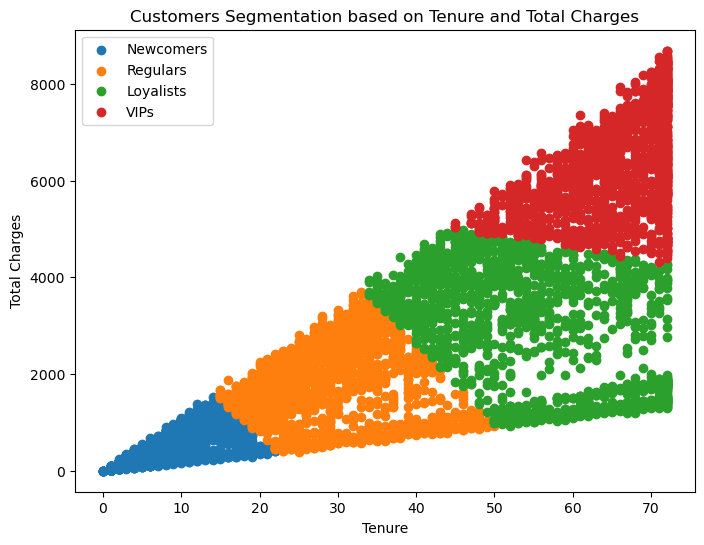

In [34]:
# features for segmentation
X = df[['tenure', 'TotalCharges']]

# Standardize the features (important for K-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# number of clusters (k)
k = 4

# K-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

# cluster labels
cluster_labels = kmeans.labels_

df['Cluster'] = cluster_labels

clusters = df.groupby('Cluster', as_index = False).agg({"tenure" : "mean"})

classes = ["Newcomers", "Regulars", "Loyalists", "VIPs"]

df["Classes"] = ""

for i, c in enumerate(classes):
    df.loc[df["Cluster"] == int(clusters.loc[clusters["tenure"] == clusters["tenure"].min()]["Cluster"]), "Classes"] = classes[i]
    clusters = clusters.loc[clusters["tenure"] != clusters["tenure"].min()]


# Plot the clusters
plt.figure(figsize=(8, 6))
for cluster in classes:
    plt.scatter(df[df['Classes'] == cluster]['tenure'], 
                df[df['Classes'] == cluster]['TotalCharges'], 
                label='{}'.format(cluster))
plt.xlabel('Tenure')
plt.ylabel('Total Charges')
plt.title('Customers Segmentation based on Tenure and Total Charges')
plt.legend()
plt.show()

Working with business experts would be crucial here : it will help define more features, define a more correct number of clusters, give more importance to some features and better define the clusters. But for this technical test purpose, we would go with those definitions :
* Newcomers : The newcomers are customers with low TotalCharges and tenure. They are new with the company and still have not spent much money.
* Regulars : The customers in this cluster would represent clients with a moderate level of loyalty and spending.
* Loyalists : This cluster represent customer with level of loyalty which is almost the same as the VIPs, but their total charges is not as high as the VIPs.
* VIPs : The VIPs represent the best customers in our company. They spent a lot of money and stayed within our company for a long time.

## Bonus 2 : Explain prediction results

In order to propose some solutions tu churning customers, we need to check why each customer would leave the company. A good solution for it is to use shapley values : 

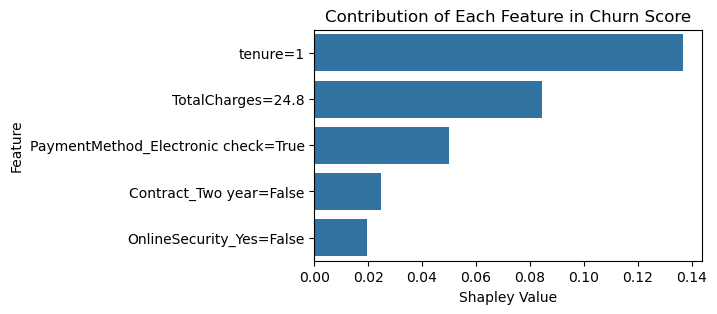

In [35]:
churn_test = X_test.copy()
churn_test["churn_prediction"] = model.predict(churn_test)

churn_test.loc[churn_test["churn_prediction"] == True]

explainer = shap.TreeExplainer(model)

# Select a specific customer's data (for example, the first customer)
churn_customer = churn_test.loc[churn_test["churn_prediction"] == True].iloc[0][X_test.columns]

# Compute Shapley values for the specific customer
shap_values = explainer.shap_values(churn_customer)

shap_df = pd.DataFrame({"Feature" : X_test.columns, "Values" : churn_customer.values, "Shapley_Value" : shap_values[1]})
shap_df["Feature"] = shap_df["Feature"] + "=" + shap_df["Values"].astype(str)
del shap_df["Values"]

shap_df = shap_df.sort_values(by = "Shapley_Value", ascending=False).head(5)

shap_df = shap_df.loc[shap_df["Shapley_Value"] > 0]

# Plot the bar plot
plt.figure(figsize=(5, 3))
sns.barplot(x='Shapley_Value', y='Feature', data=shap_df)
plt.xlabel('Shapley Value')
plt.ylabel('Feature')
plt.title('Contribution of Each Feature in Churn Score')
plt.show()

In this example, we can see that this customer might churn because he doesn't have a fiber optic and that he is not happy with his monthly charges. (If you re-run the notebook, you may get a different example)

## Important comments

Churn prediction projects should be treated as time series (We can't predict observations when training on other observations in the same month). But since we had only one month of data in this dataset, we can't do otherwise.

When dealing with statistics, we considered the sample dataset to be representative of data from sources.

## Streamlit App

Uncomment below code to build a docker image for a streamlit app

In [1]:
!pip install sagemaker-studio-image-build

  Using cached sagemaker_studio_image_build-0.6.0-py3-none-any.whl


In [2]:
!sm-docker build  telco-streamlit/

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
................[Container] 2024/05/09 12:37:26.528662 Running on CodeBuild On-demand

[Container] 2024/05/09 12:37:26.528747 Waiting for agent ping
[Container] 2024/05/09 12:37:29.738873 Waiting for DOWNLOAD_SOURCE
[Container] 2024/05/09 12:37:30.384381 Phase is DOWNLOAD_SOURCE
[Container] 2024/05/09 12:37:30.387663 CODEBUILD_SRC_DIR=/codebuild/output/src1526349318/src
[Container] 2024/05/09 12:37:30.388207 YAML location is /codebuild/output/src1526349318/src/buildspec.yml
[Container] 2024/05/09 12:37:30.391936 Setting HTTP client timeout to higher timeout for S3 source
[Container] 2024/05/09 12:37:30.392051 Processing environment variables
[Container] 2024/05/09 12:37:30.441769 No runtime version selected in buildspec.
[Container] 2024/05/09 12:37:30.457314 Moving to director

In [ ]:
# Image URI: 211125691730.dkr.ecr.eu-north-1.amazonaws.com/sagemaker-studio:latest